pygame 2.6.1 (SDL 2.28.4, Python 3.12.4)
Hello from the pygame community. https://www.pygame.org/contribute.html


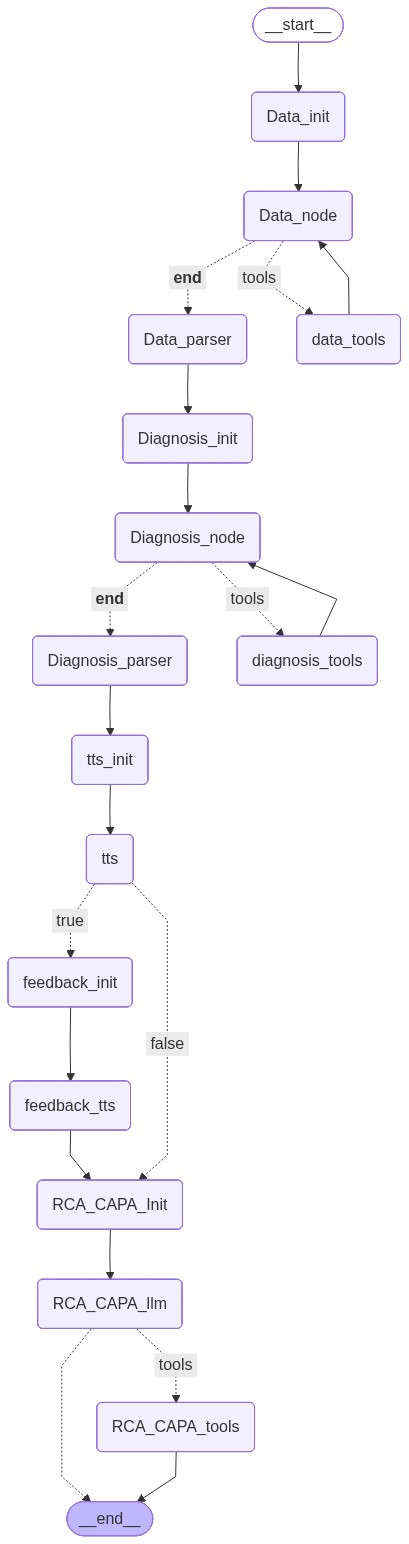

In [1]:
from main_agent import agent

import requests
from IPython.display import Image, display

mermaid_code = agent.get_graph().draw_mermaid()

import base64
graphbytes = mermaid_code.encode("ascii")
base64_bytes = base64.b64encode(graphbytes)
base64_string = base64_bytes.decode("ascii")

url = "https://mermaid.ink/img/" + base64_string
response = requests.get(url)

if response.status_code == 200:
    display(Image(response.content))
else:
    print("Could not render image automatically.")